<a href="https://colab.research.google.com/github/vdmello17/Salary/blob/main/Salaries3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import pandas as pd
# df = pd.read_csv('salaries.csv')
# # df = pd.read_excel('grades.xlsx', sheet_name = 'Period 5', delimiter='\t', skiprows=9)
# print(df.info())
# df.head()

In [ ]:
import sqlite3
import csv

# Connect to SQLite database
conn = sqlite3.connect('salaries.db')
cursor = conn.cursor()

# Create tables with full forms
cursor.execute('''
CREATE TABLE IF NOT EXISTS ExperienceLevel (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    experience_level TEXT UNIQUE,
    full_form TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS EmploymentType (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    employment_type TEXT UNIQUE,
    full_form TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS JobTitle (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    job_title TEXT UNIQUE
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS EmployeeResidence (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    employee_residence TEXT UNIQUE
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS RemoteRatio (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    remote_ratio INTEGER UNIQUE
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS CompanyLocation (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    company_location TEXT UNIQUE
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS CompanySize (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    company_size TEXT UNIQUE,
    full_form TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Salaries (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    work_year INTEGER,
    experience_level_id INTEGER,
    employment_type_id INTEGER,
    job_title_id INTEGER,
    salary INTEGER,
    salary_currency TEXT,
    salary_in_usd INTEGER,
    employee_residence_id INTEGER,
    remote_ratio_id INTEGER,
    company_location_id INTEGER,
    company_size_id INTEGER,
    FOREIGN KEY (experience_level_id) REFERENCES ExperienceLevel (id),
    FOREIGN KEY (employment_type_id) REFERENCES EmploymentType (id),
    FOREIGN KEY (job_title_id) REFERENCES JobTitle (id),
    FOREIGN KEY (employee_residence_id) REFERENCES EmployeeResidence (id),
    FOREIGN KEY (remote_ratio_id) REFERENCES RemoteRatio (id),
    FOREIGN KEY (company_location_id) REFERENCES CompanyLocation (id),
    FOREIGN KEY (company_size_id) REFERENCES CompanySize (id)
)
''')

In [ ]:
# Helper function to insert or get id from a table with full forms
def insert_or_get_id(cursor, table, column, value, full_form=None):
    cursor.execute(f"SELECT id FROM {table} WHERE {column} = ?", (value,))
    row = cursor.fetchone()
    if row:
        return row[0]
    if full_form:
        cursor.execute(f"INSERT INTO {table} ({column}, full_form) VALUES (?, ?)", (value, full_form))
    else:
        cursor.execute(f"INSERT INTO {table} ({column}) VALUES (?)", (value,))
    return cursor.lastrowid

# Define full forms for relevant columns
experience_level_full_forms = {
    'EN': 'Entry-level',
    'MI': 'Mid-level',
    'SE': 'Senior-level',
    'EX': 'Executive-level'
}

employment_type_full_forms = {
    'FT': 'Full-time',
    'PT': 'Part-time',
    'CT': 'Contract',
    'FL': 'Freelance'
}

company_size_full_forms = {
    'S': 'Small',
    'M': 'Medium',
    'L': 'Large'
}

# Insert unique values into individual tables
with open('salaries.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        experience_level_id = insert_or_get_id(cursor, 'ExperienceLevel', 'experience_level', row['experience_level'], experience_level_full_forms.get(row['experience_level']))
        employment_type_id = insert_or_get_id(cursor, 'EmploymentType', 'employment_type', row['employment_type'], employment_type_full_forms.get(row['employment_type']))
        job_title_id = insert_or_get_id(cursor, 'JobTitle', 'job_title', row['job_title'])
        employee_residence_id = insert_or_get_id(cursor, 'EmployeeResidence', 'employee_residence', row['employee_residence'])
        remote_ratio_id = insert_or_get_id(cursor, 'RemoteRatio', 'remote_ratio', row['remote_ratio'])
        company_location_id = insert_or_get_id(cursor, 'CompanyLocation', 'company_location', row['company_location'])
        company_size_id = insert_or_get_id(cursor, 'CompanySize', 'company_size', row['company_size'], company_size_full_forms.get(row['company_size']))

        cursor.execute('''
            INSERT INTO Salaries (
                work_year, experience_level_id, employment_type_id, job_title_id, salary,
                salary_currency, salary_in_usd, employee_residence_id, remote_ratio_id,
                company_location_id, company_size_id
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            row['work_year'], experience_level_id, employment_type_id, job_title_id,
            row['salary'], row['salary_currency'], row['salary_in_usd'],
            employee_residence_id, remote_ratio_id, company_location_id, company_size_id
        ))

# Commit the changes and close the connection
conn.commit()
conn.close()

In [ ]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('salaries.db')

# SQL query with JOINs to fetch the data
query = '''
SELECT
    s.id,
    s.work_year,
    e.experience_level,
    e.full_form AS experience_level_full_form,
    et.employment_type,
    et.full_form AS employment_type_full_form,
    j.job_title,
    s.salary,
    s.salary_currency,
    s.salary_in_usd,
    er.employee_residence,
    rr.remote_ratio,
    cl.company_location,
    cs.company_size,
    cs.full_form AS company_size_full_form
FROM
    Salaries s
JOIN
    ExperienceLevel e ON s.experience_level_id = e.id
JOIN
    EmploymentType et ON s.employment_type_id = et.id
JOIN
    JobTitle j ON s.job_title_id = j.id
JOIN
    EmployeeResidence er ON s.employee_residence_id = er.id
JOIN
    RemoteRatio rr ON s.remote_ratio_id = rr.id
JOIN
    CompanyLocation cl ON s.company_location_id = cl.id
JOIN
    CompanySize cs ON s.company_size_id = cs.id
'''

# Load data into Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()


In [ ]:
df.head()

,id,work_year,experience_level,experience_level_full_form,employment_type,employment_type_full_form,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,company_size_full_form
0,1,2024,SE,Senior-level,FT,Full-time,AI Engineer,202730,USD,202730,US,0,US,M,Medium
1,2,2024,SE,Senior-level,FT,Full-time,AI Engineer,92118,USD,92118,US,0,US,M,Medium
2,3,2024,SE,Senior-level,FT,Full-time,Data Engineer,130500,USD,130500,US,0,US,M,Medium
3,4,2024,SE,Senior-level,FT,Full-time,Data Engineer,96000,USD,96000,US,0,US,M,Medium
4,5,2024,SE,Senior-level,FT,Full-time,Machine Learning Engineer,190000,USD,190000,US,0,US,M,Medium


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33068 entries, 0 to 33067
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          33068 non-null  int64 
 1   work_year                   33068 non-null  int64 
 2   experience_level            33068 non-null  object
 3   experience_level_full_form  33068 non-null  object
 4   employment_type             33068 non-null  object
 5   employment_type_full_form   33068 non-null  object
 6   job_title                   33068 non-null  object
 7   salary                      33068 non-null  int64 
 8   salary_currency             33068 non-null  object
 9   salary_in_usd               33068 non-null  int64 
 10  employee_residence          33068 non-null  object
 11  remote_ratio                33068 non-null  int64 
 12  company_location            33068 non-null  object
 13  company_size                33068 non-null  ob

In [ ]:
df.columns

Index(['id', 'work_year', 'experience_level', 'experience_level_full_form',
       'employment_type', 'employment_type_full_form', 'job_title', 'salary',
       'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size',
       'company_size_full_form'],
      dtype='object')

In [ ]:
df['experience_level'].value_counts().head()

experience_level
SE    21340
MI     8076
EN     2650
EX     1002
Name: count, dtype: int64

In [ ]:
# df['company_location'].value_counts().head()

In [ ]:
# #Filtering only US data, since most belong to US
# filtered_df = df[(df['employee_residence'] == 'US') & (df['company_location'] == 'US')]

# from sklearn.model_selection import train_test_split

# # Assuming 'salary_in_usd' is the target variable
# X = filtered_df[['work_year', 'experience_level', 'employment_type',
#        'salary_currency', 'employee_residence', 'remote_ratio',
#        'company_location', 'company_size']]
# y = filtered_df['salary_in_usd']

# # Perform train/test split without stratification
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

relevant_columns = ['work_year', 'experience_level', 'employment_type',
       'salary_currency', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size', 'salary_in_usd', ]

df = df[relevant_columns]

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 23147 entries, 7315 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           23147 non-null  int64 
 1   experience_level    23147 non-null  object
 2   employment_type     23147 non-null  object
 3   salary_currency     23147 non-null  object
 4   employee_residence  23147 non-null  object
 5   remote_ratio        23147 non-null  int64 
 6   company_location    23147 non-null  object
 7   company_size        23147 non-null  object
 8   salary_in_usd       23147 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1.8+ MB
None


,work_year,experience_level,employment_type,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
7315,2023,SE,FT,USD,PL,100,PL,M,110000
25507,2023,SE,FT,USD,US,0,US,M,113500
7691,2023,SE,FT,USD,US,100,US,M,198200
5130,2024,EX,FT,USD,US,100,US,M,120000
14600,2023,SE,FT,USD,US,100,US,M,184000


In [ ]:
!pip install ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport

# Generate profile report for train data
profile = ProfileReport(train, title='Train Data Profile Report', explorative=True)
profile.to_file("train_data_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Correlation Heatmap

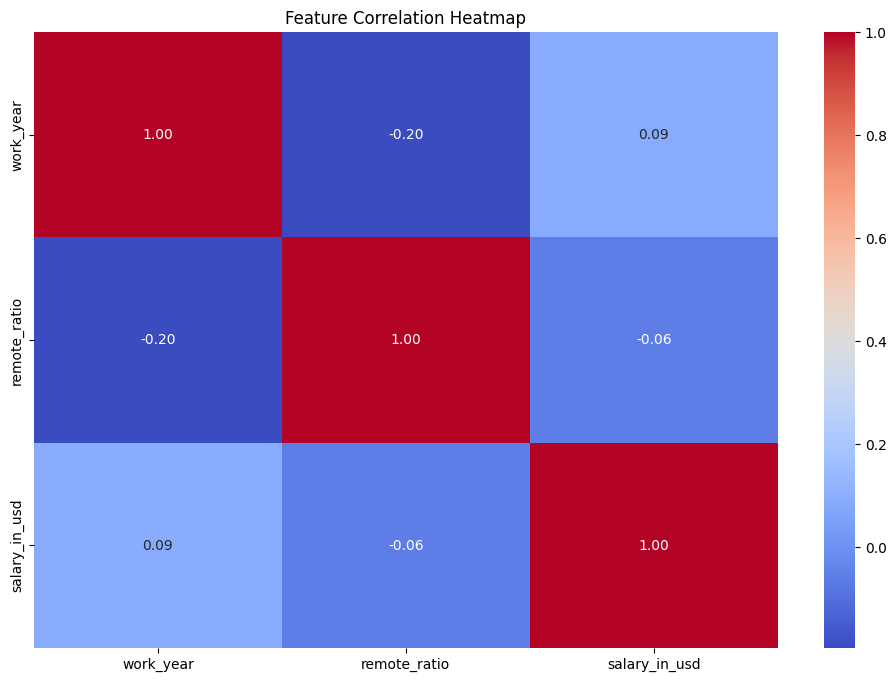

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Selecting only numerical columns for correlation matrix
numerical_data = train.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')

%matplotlib inline
plt.show()

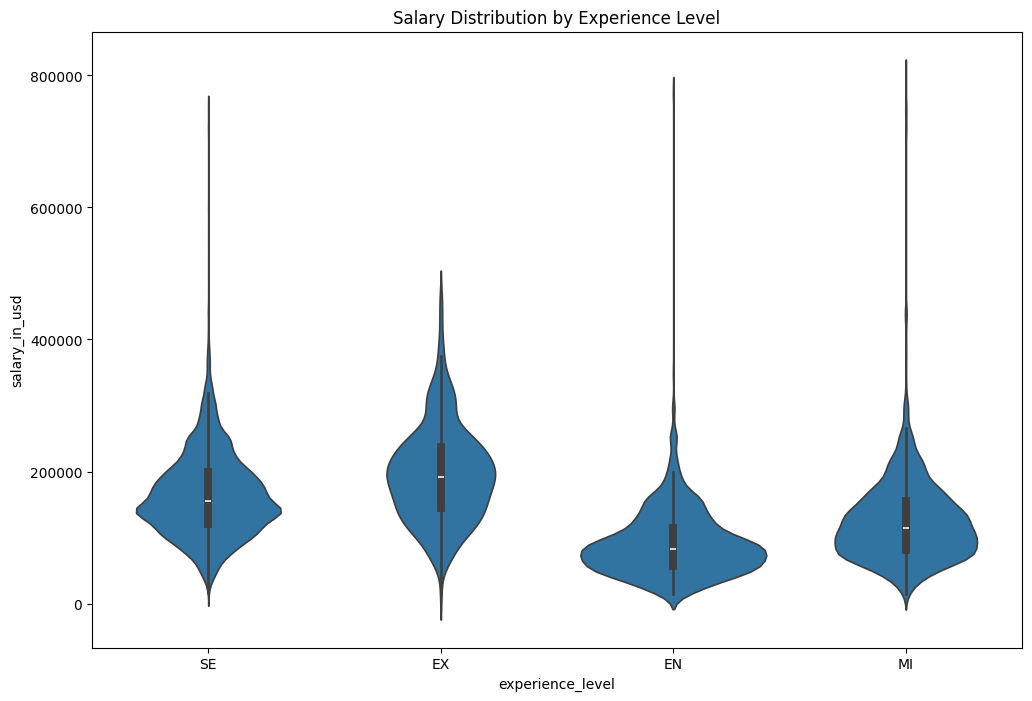

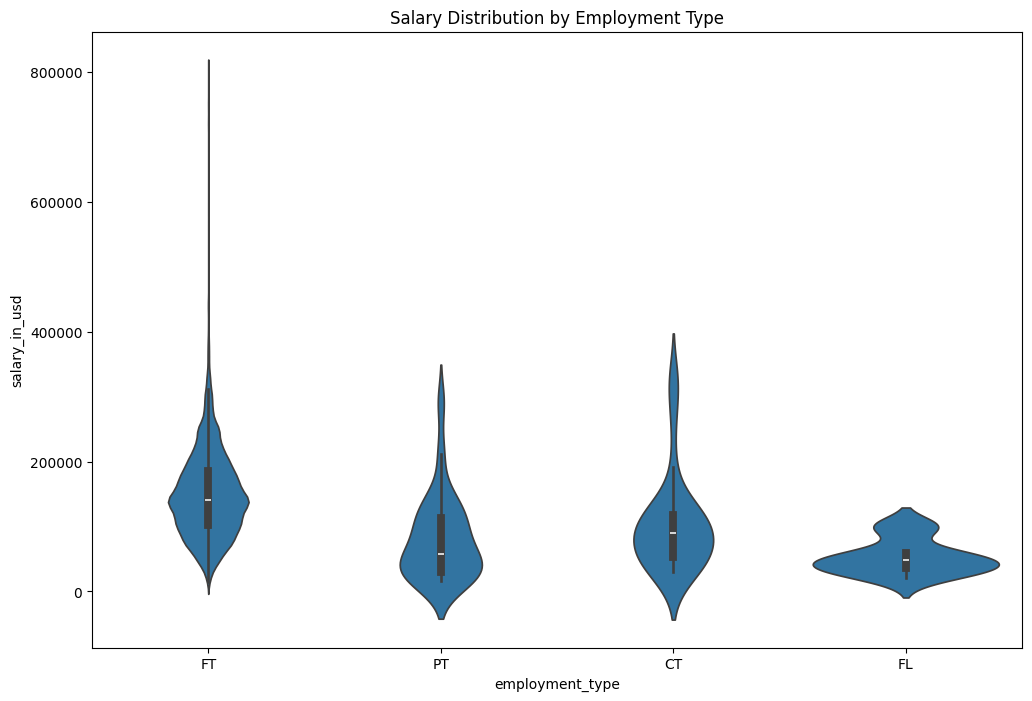

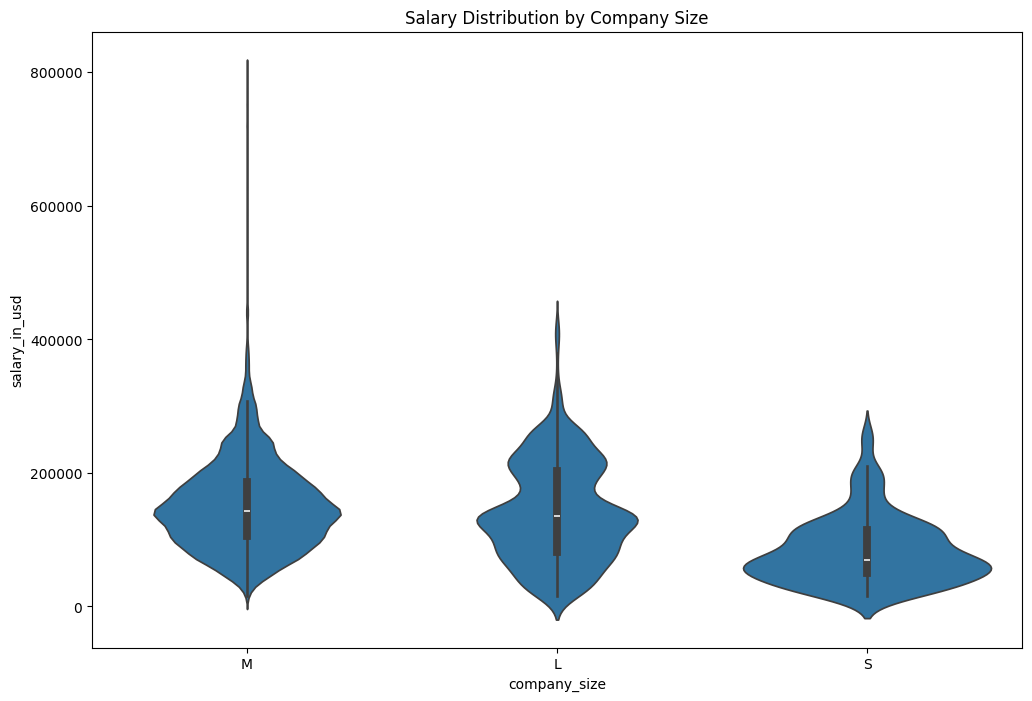

In [ ]:
# Violin plot for Experience Level
plt.figure(figsize=(12, 8))
sns.violinplot(x=train['experience_level'], y=train['salary_in_usd'])
plt.title('Salary Distribution by Experience Level')
plt.show()

# Violin plot for Employment Type
plt.figure(figsize=(12, 8))
sns.violinplot(x=train['employment_type'], y=train['salary_in_usd'])
plt.title('Salary Distribution by Employment Type')
plt.show()

# Violin plot for Company Size
plt.figure(figsize=(12, 8))
sns.violinplot(x=train['company_size'], y=train['salary_in_usd'])
plt.title('Salary Distribution by Company Size')
plt.show()


In [ ]:
train.columns

Index(['work_year', 'experience_level', 'employment_type', 'salary_currency',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'salary_in_usd'],
      dtype='object')

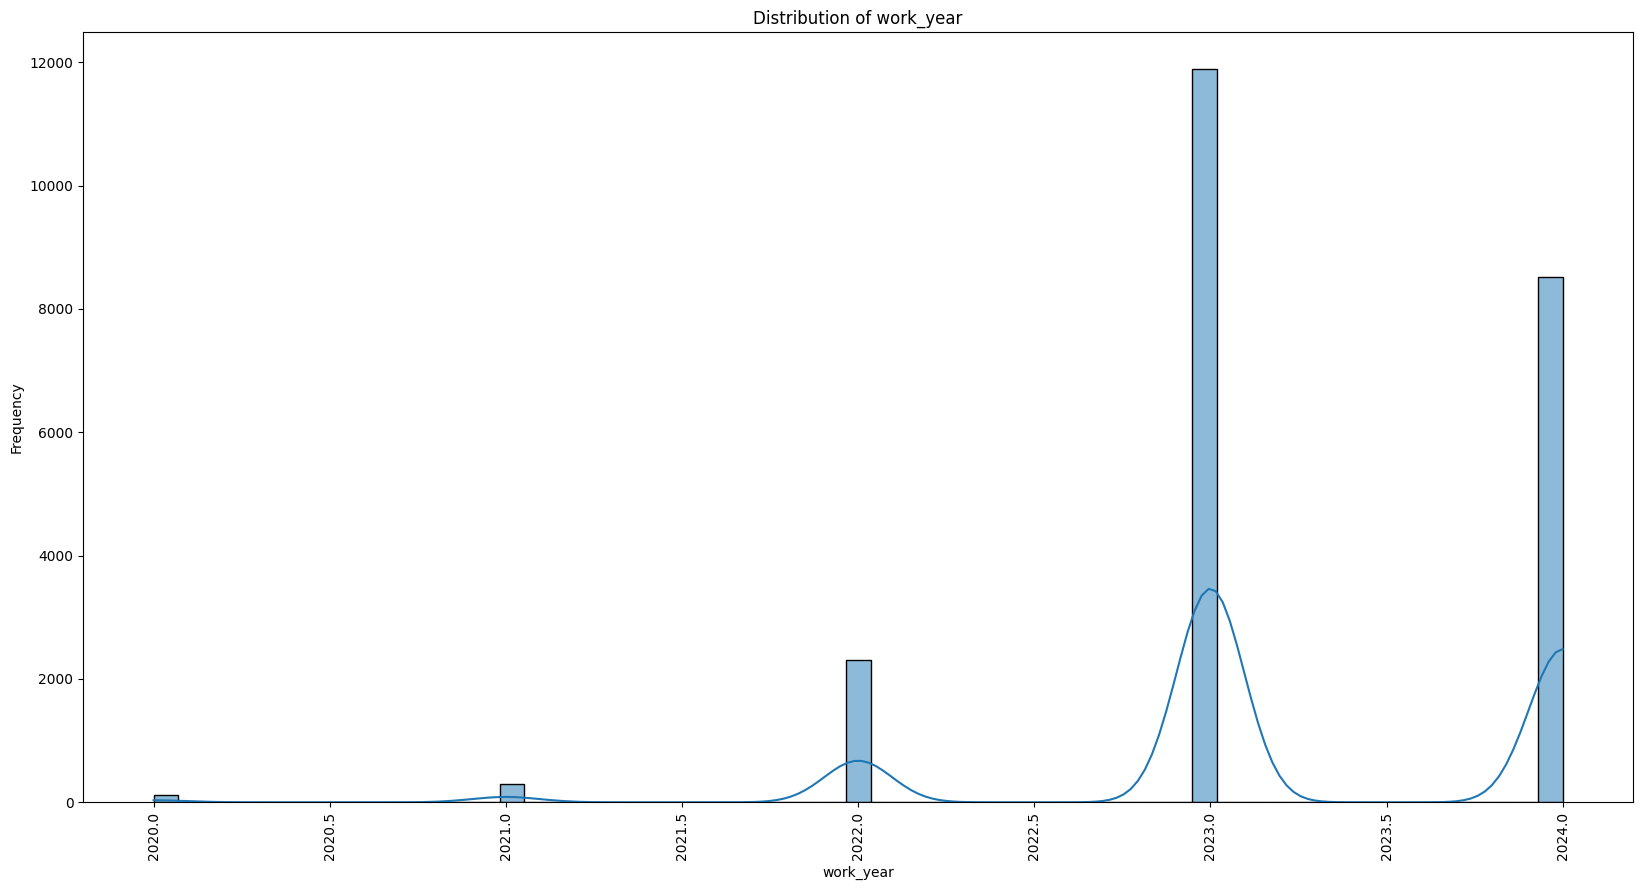

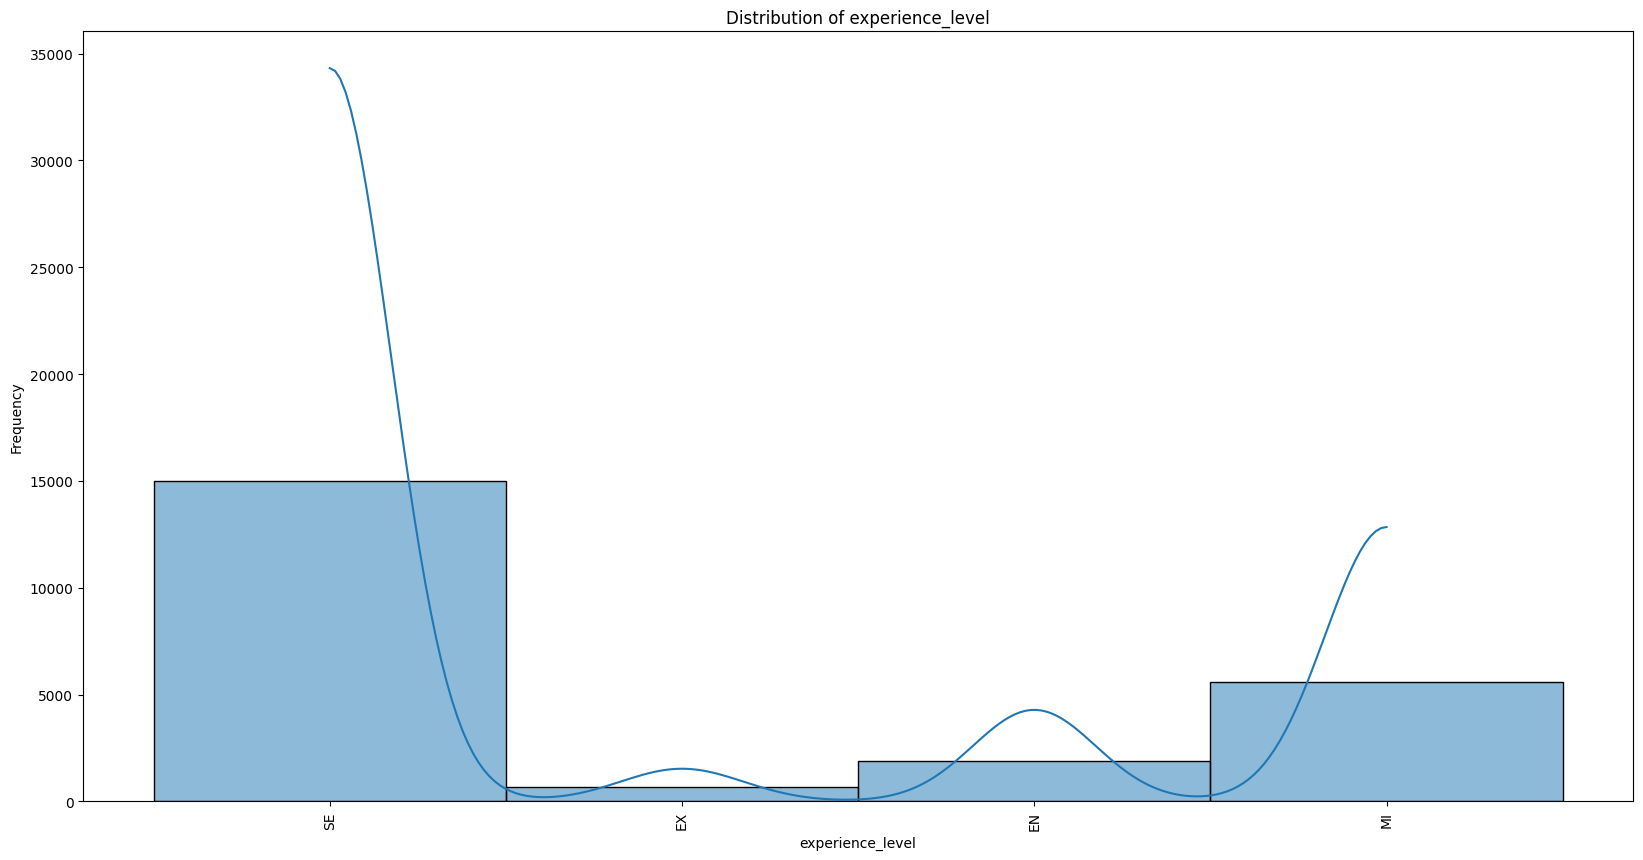

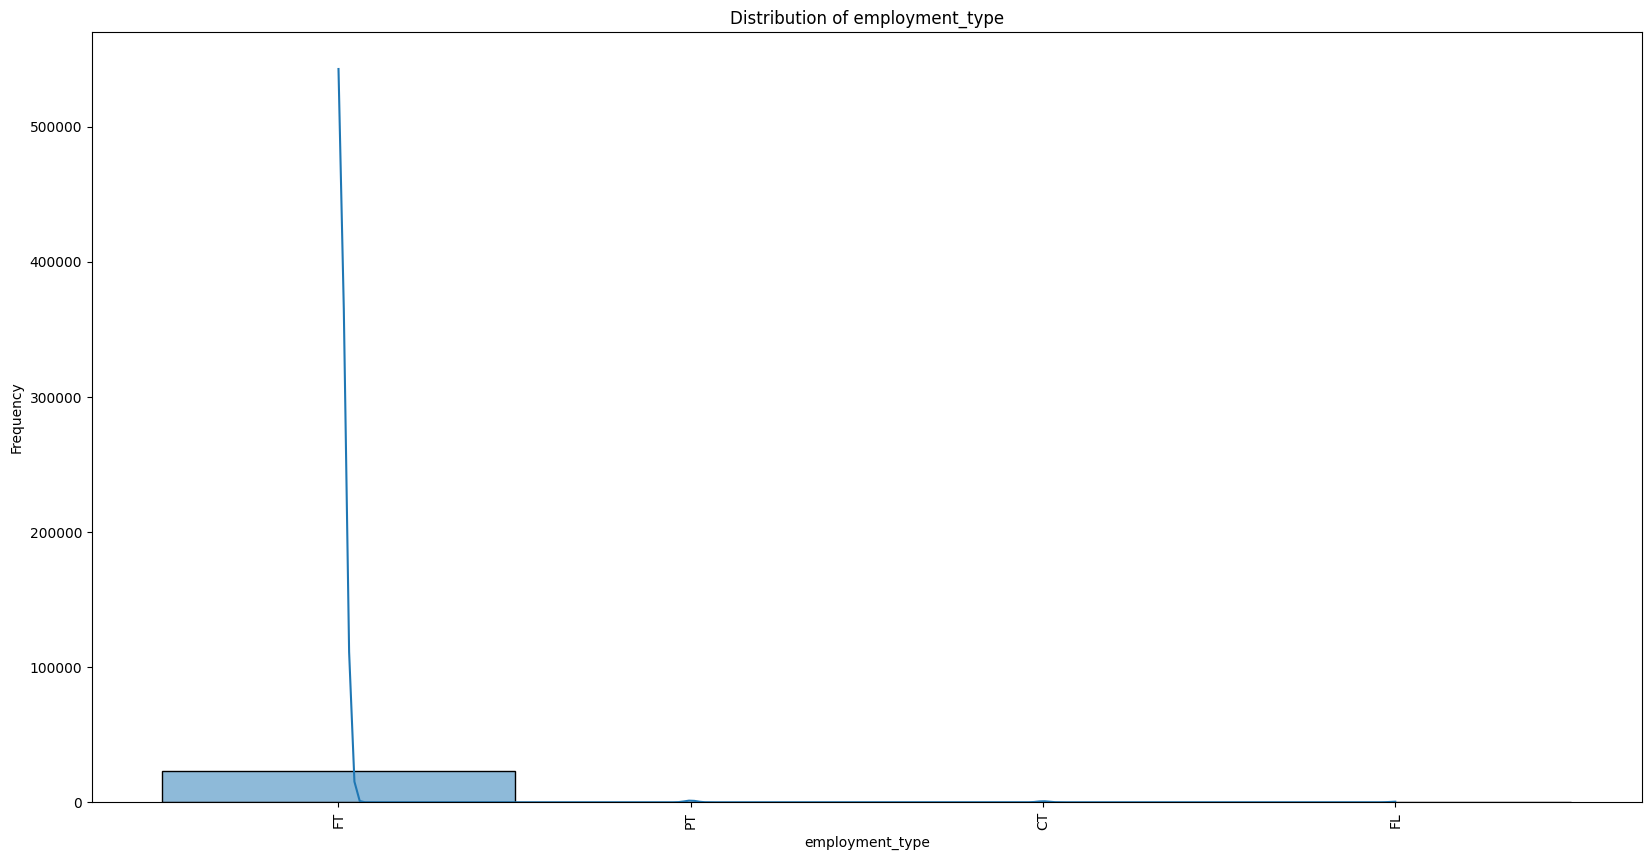

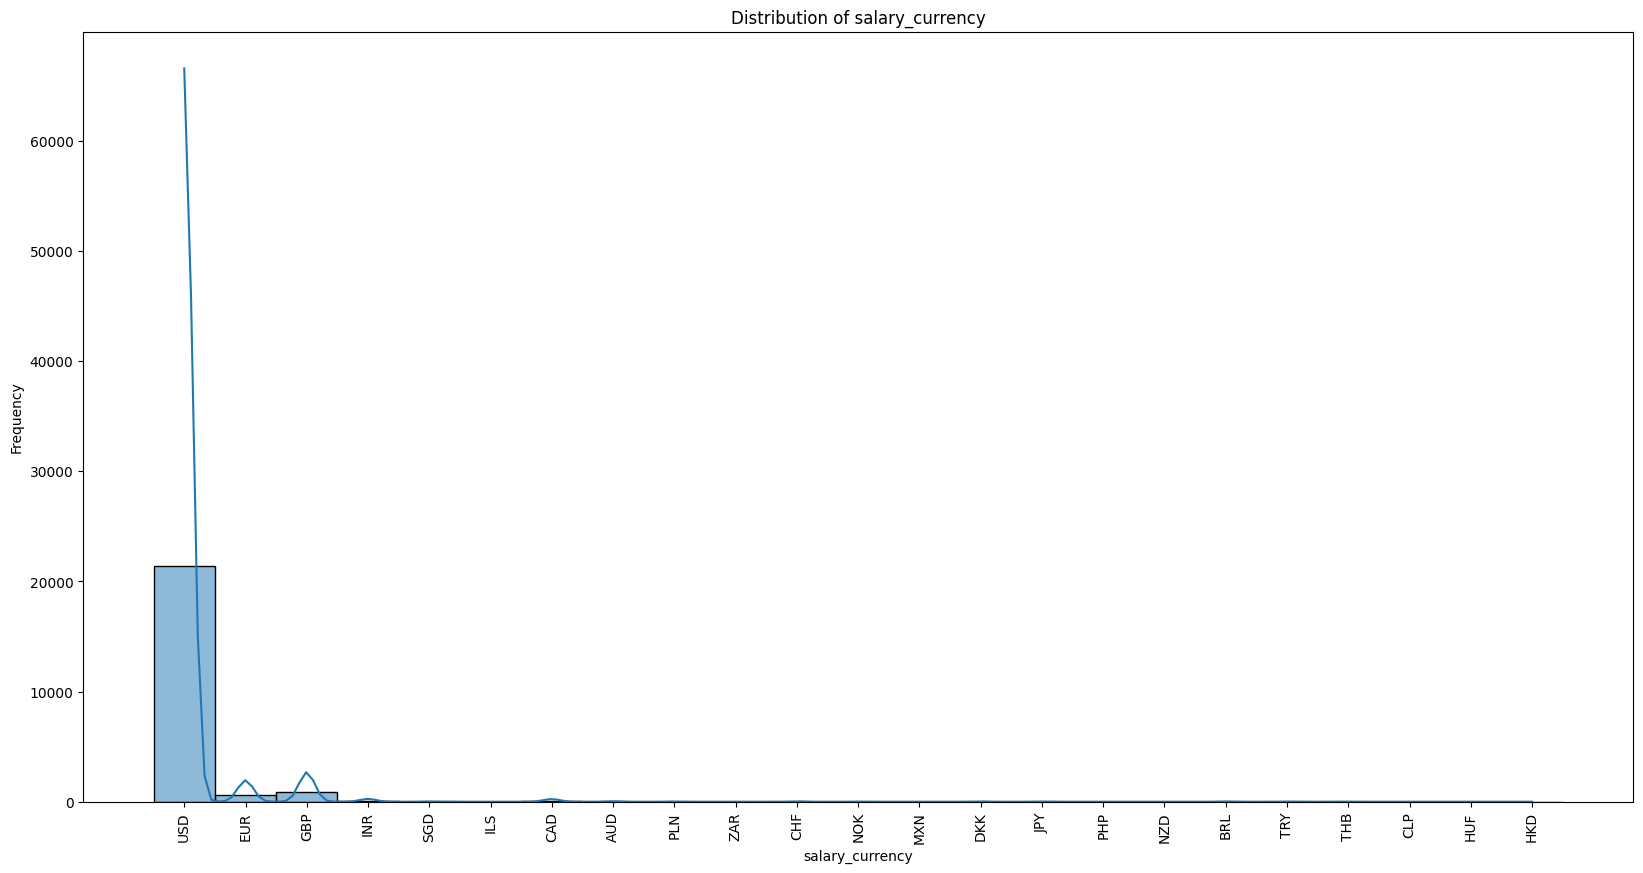

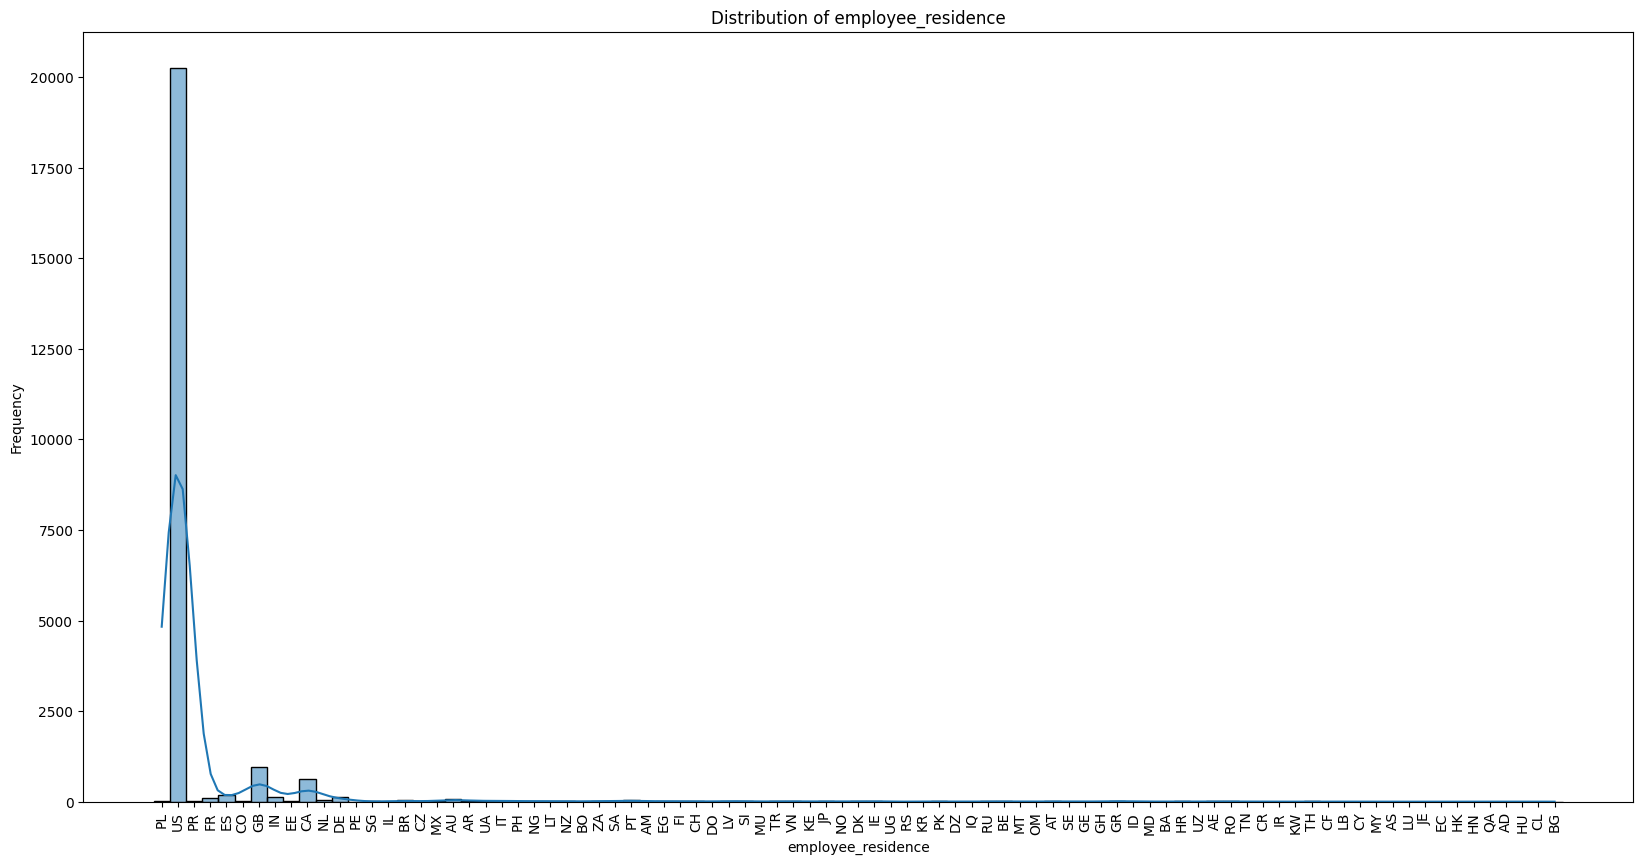

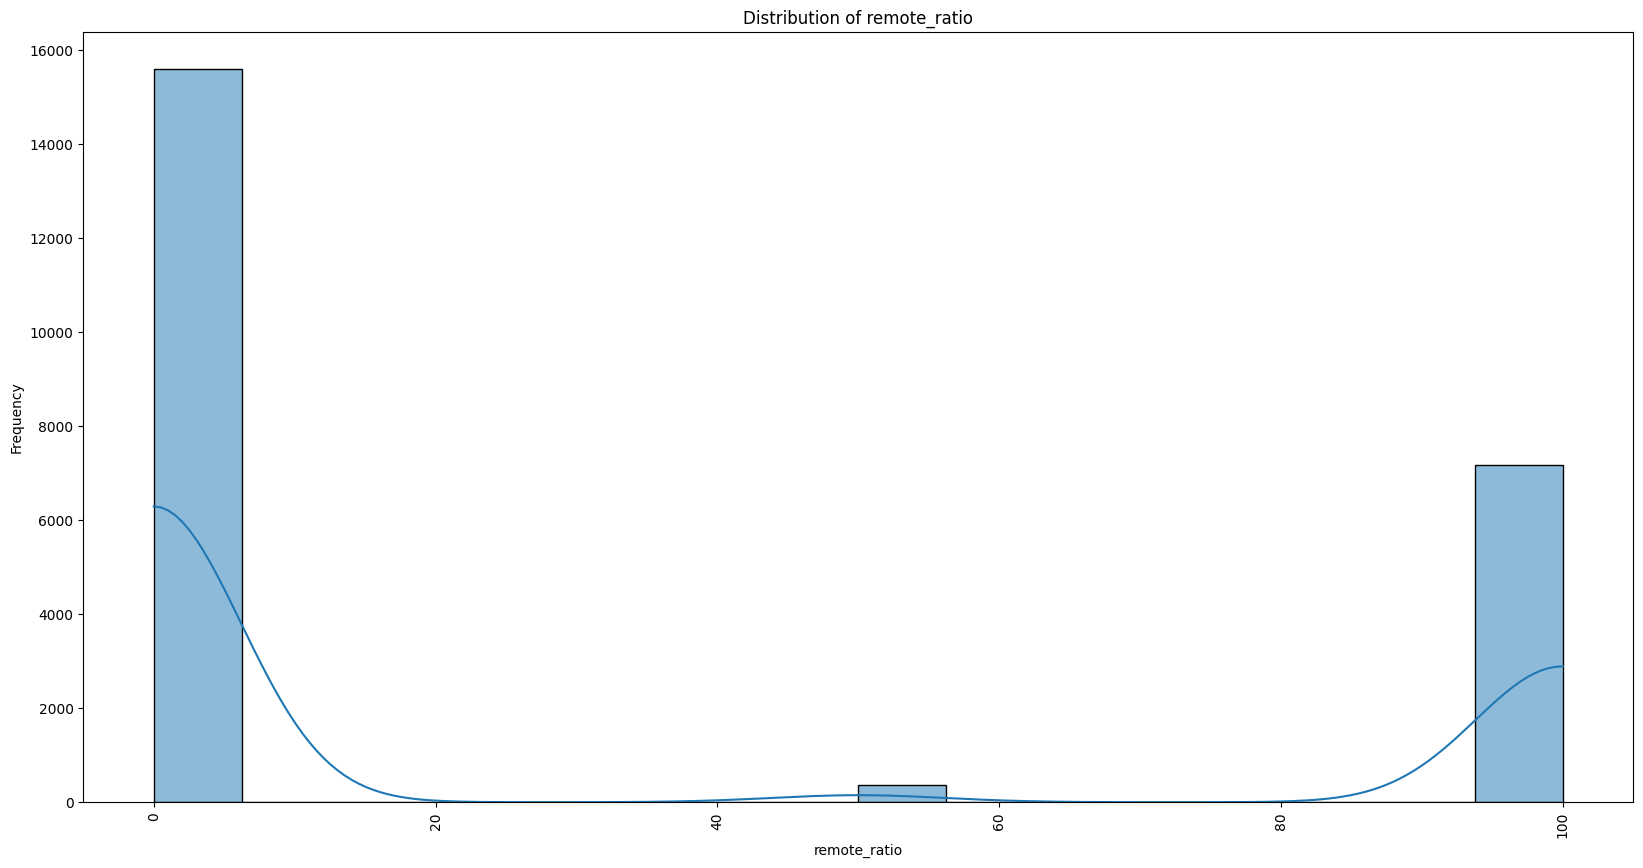

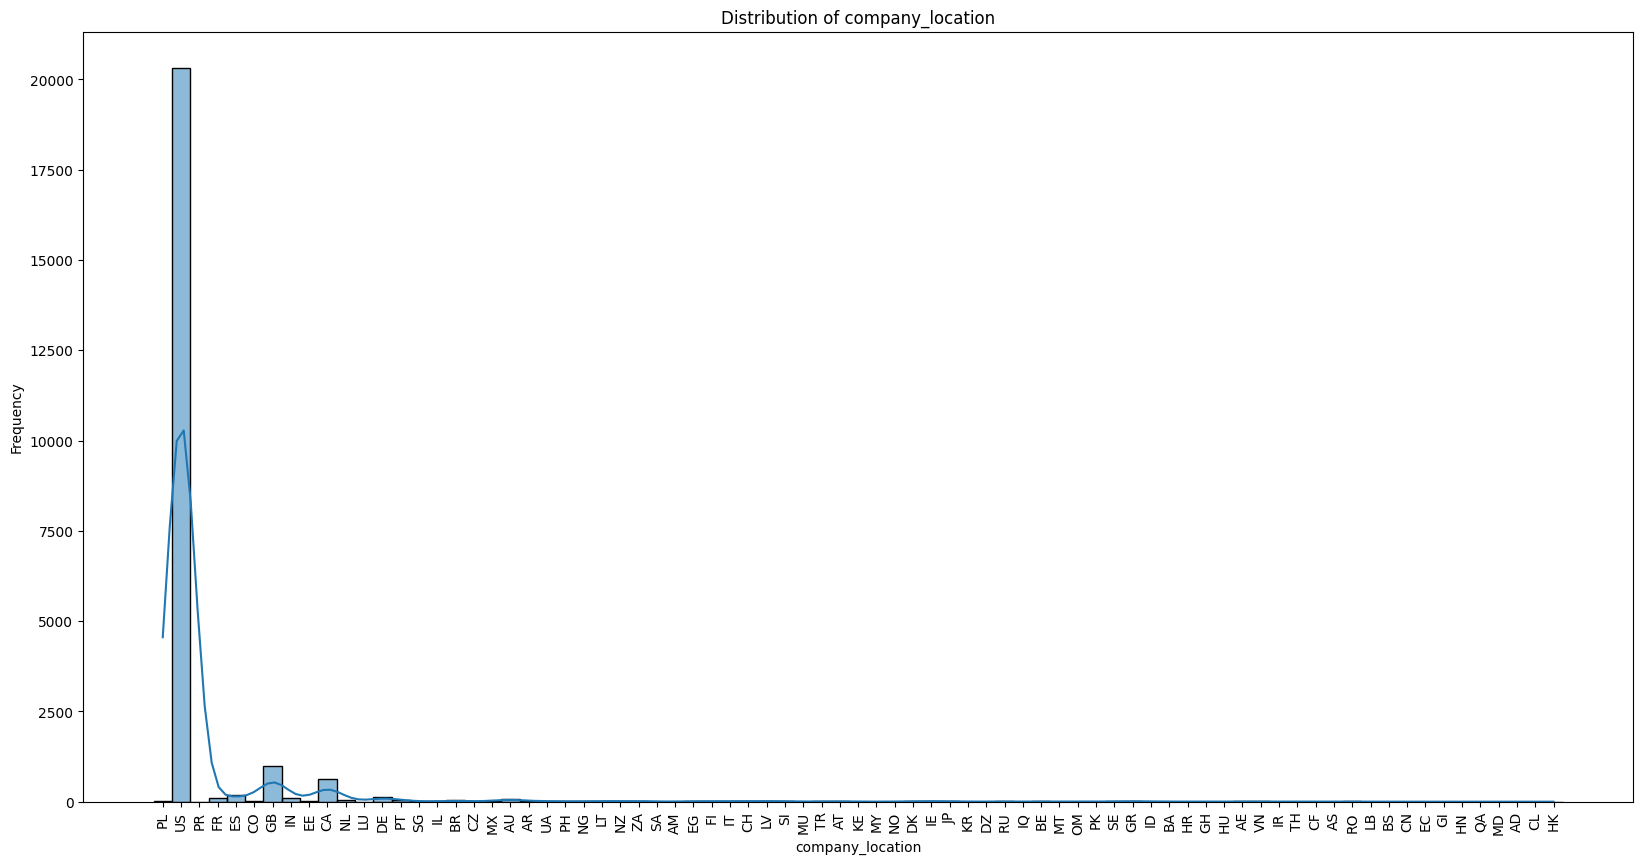

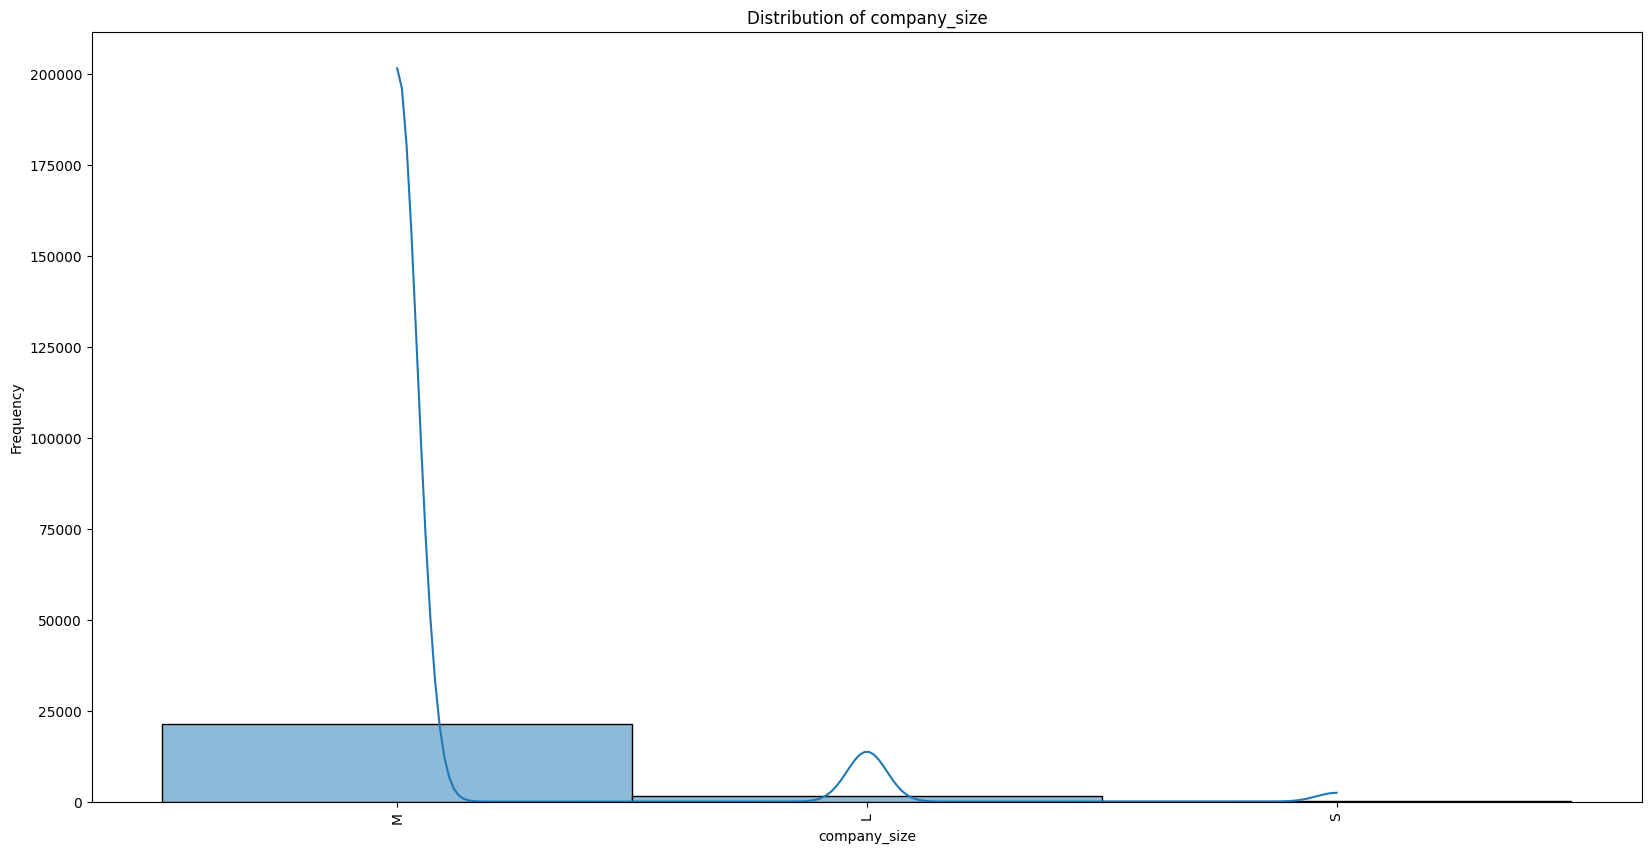

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train is your DataFrame
columns = ['work_year', 'experience_level', 'employment_type',
           'salary_currency', 'employee_residence', 'remote_ratio',
           'company_location', 'company_size']

# Loop through each column and plot the histogram
for column in columns:
    plt.figure(figsize=(20, 10))
    sns.histplot(data=train, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate x labels if necessary
    plt.show()


In [ ]:
df = df.drop(columns=['salary_currency'])
df = df[(df['employee_residence'] == 'US') & (df['company_location'] == 'US') & (df['employment_type'] == 'FT')]
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# import pandas as pd
# import numpy as np

# class Preprocessor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.num_pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#         ])

#         self.cat_pipeline = Pipeline([
#             ('onehot', OneHotEncoder(handle_unknown='ignore')),
#         ])

#         self.preprocessor = None
#         self.num_features = ['remote_ratio']
#         self.cat_features = [
#             'work_year', 'experience_level', 'employment_type',
#             'salary_currency', 'employee_residence', 'company_location', 'company_size'
#         ]

#     def fit(self, X, y=None):
#         self.preprocessor = ColumnTransformer([
#             ('num', self.num_pipeline, self.num_features),
#             ('cat', self.cat_pipeline, self.cat_features),
#         ])

#         self.preprocessor.fit(X)
#         return self

#     def transform(self, X, y=None):
#         # Filter rows where 'employee_residence' and 'company_location' are 'US'
#         X_filtered = X[(X['employee_residence'] == 'US') & (X['company_location'] == 'US')]

#         return self.preprocessor.transform(X_filtered)

#     def get_feature_names(self):
#         num_feature_names = self.num_features
#         cat_feature_names = self.preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(self.cat_features)
#         return np.concatenate([num_feature_names, cat_feature_names])


# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# import pandas as pd
# import numpy as np

# class DataPreprocessor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.num_pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#         ])

#         self.cat_pipeline = Pipeline([
#             ('onehot', OneHotEncoder(handle_unknown='ignore')),
#         ])

#         self.preprocessor = None
#         self.num_features = ['remote_ratio']
#         self.cat_features = [
#             'work_year', 'experience_level', 'employment_type',
#             'salary_currency', 'employee_residence', 'company_location', 'company_size'
#         ]

#     def fit(self, X, y=None):
#         self.preprocessor = ColumnTransformer([
#             ('num', self.num_pipeline, self.num_features),
#             ('cat', self.cat_pipeline, self.cat_features),
#         ])

#         self.preprocessor.fit(X)
#         return self

#     def transform(self, X, y=None):
#         return self.preprocessor.transform(X)

#     def get_feature_names(self):
#         num_feature_names = self.num_features
#         cat_feature_names = self.preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(self.cat_features)
#         return np.concatenate([num_feature_names, cat_feature_names])

# # Example usage
# # df = pd.DataFrame(data)

# # preprocessor = DataPreprocessor()
# # preprocessor.fit(df)
# # transformed_data = preprocessor.transform(df)

# # # Converting to a DataFrame
# # feature_names = preprocessor.get_feature_names()
# # transformed_df = pd.DataFrame(transformed_data.toarray(), columns=feature_names)

# # print(transformed_df)


In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# import pandas as pd
# import numpy as np

# class Preprocessor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.num_features = ['remote_ratio']
#         self.cat_features = [
#             'work_year', 'experience_level', 'employment_type',
#             'employee_residence', 'company_location', 'company_size'
#         ]

#     def fit(self, X, y=None):

#         # Create and fit the Simple Imputer for numerical features
#         self.imputer = SimpleImputer(strategy='median')
#         self.imputer.fit(X[self.num_features])

#         # Create and fit the Standard Scaler for numerical features
#         self.scaler = StandardScaler()
#         self.scaler.fit(X[self.num_features])

#         # Create and fit the OneHotEncoder for categorical features
#         self.onehot = OneHotEncoder(handle_unknown='ignore')
#         self.onehot.fit(X[self.cat_features])

#         return self

#     def transform(self, X):
#         # Filter rows where 'employee_residence' and 'company_location' are 'US'
#         X_filtered = X[(X['employee_residence'] == 'US') & (X['company_location'] == 'US') & (X['employment_type'] == 'FT')]

#         # Apply Simple Imputer
#         imputed_cols = self.imputer.transform(X_filtered[self.num_features])

#         # Apply Standard Scaler
#         scaled_cols = self.scaler.transform(imputed_cols)

#         # Apply OneHotEncoder
#         onehot_cols = self.onehot.transform(X_filtered[self.cat_features])

#         # Create a DataFrame for the transformed numerical data
#         transformed_df = X_filtered.copy()
#         transformed_df[self.num_features] = scaled_cols

#         # Drop existing categorical columns
#         transformed_df = transformed_df.drop(self.cat_features, axis=1)

#         # Create a DataFrame for the one-hot encoded categorical data
#         onehot_df = pd.DataFrame(onehot_cols.toarray(), columns=self.onehot.get_feature_names_out(self.cat_features))

#         # Reset indices to ensure proper alignment
#         transformed_df.reset_index(drop=True, inplace=True)
#         onehot_df.reset_index(drop=True, inplace=True)

#         # Print shapes to debug
#         print("Shape of transformed_df (numerical):", transformed_df.shape)
#         print("Shape of onehot_df (categorical):", onehot_df.shape)

#         # Combine numerical and one-hot encoded columns
#         transformed_df = pd.concat([transformed_df, onehot_df], axis=1)

#         return transformed_df

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin):
    # Train our custom preprocessors
    numerical_columns = [
        'remote_ratio'
    ]
    categorical_columns = [
        'work_year', 'experience_level', 'employment_type',
        'employee_residence', 'company_location', 'company_size'
    ]

    def fit(self, X, y=None):

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])

        # Create and fit Standard Scaler
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns])

        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])

        return self

    def transform(self, X):

        # Filter rows where 'employee_residence' and 'company_location' are 'US'
        # X = X[(X['employee_residence'] == 'US') & (X['company_location'] == 'US') & (X['employment_type'] == 'FT')]

        # Apply simple imputer
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])

        # Copy the df
        transformed_df = X.copy()

        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])

        # Drop existing categorical columns and replace with one hot equivalent
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1)
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)

        return transformed_df



        # Apply Simple Imputer
        # imputed_cols = self.imputer.transform(X_filtered[self.num_features])

        # # Apply Standard Scaler
        # scaled_cols = self.scaler.transform(imputed_cols)

        # # Apply OneHotEncoder
        # onehot_cols = self.onehot.transform(X_filtered[self.cat_features])

        # Create a DataFrame for the transformed numerical data
        # transformed_df = X_filtered.copy()
        # transformed_df[self.num_features] = scaled_cols

        # Drop existing categorical columns
        # transformed_df = transformed_df.drop(self.cat_features, axis=1)

        # # Create a DataFrame for the one-hot encoded categorical data
        # onehot_df = pd.DataFrame(onehot_cols.toarray(), columns=self.onehot.get_feature_names_out(self.cat_features))

        # # Reset indices to ensure proper alignment
        # transformed_df.reset_index(drop=True, inplace=True)
        # onehot_df.reset_index(drop=True, inplace=True)

        # # Print shapes to debug
        # print("Shape of transformed_df (numerical):", transformed_df.shape)
        # print("Shape of onehot_df (categorical):", onehot_df.shape)

        # # Combine numerical and one-hot encoded columns
        # transformed_df = pd.concat([transformed_df, onehot_df], axis=1)

        # return transformed_df

In [ ]:
preprocessor = Preprocessor()
preprocessor.fit(train)
train_fixed = preprocessor.transform(train)

In [ ]:
train_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20190 entries, 7932 to 26816
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   remote_ratio           20190 non-null  float64
 1   salary_in_usd          20190 non-null  int64  
 2   work_year_2020         20190 non-null  int64  
 3   work_year_2021         20190 non-null  int64  
 4   work_year_2022         20190 non-null  int64  
 5   work_year_2023         20190 non-null  int64  
 6   work_year_2024         20190 non-null  int64  
 7   experience_level_EN    20190 non-null  int64  
 8   experience_level_EX    20190 non-null  int64  
 9   experience_level_MI    20190 non-null  int64  
 10  experience_level_SE    20190 non-null  int64  
 11  employment_type_FT     20190 non-null  int64  
 12  employee_residence_US  20190 non-null  int64  
 13  company_location_US    20190 non-null  int64  
 14  company_size_L         20190 non-null  int64  
 15  comp

In [ ]:
train_fixed

,remote_ratio,salary_in_usd,work_year_2020,work_year_2021,work_year_2022,work_year_2023,work_year_2024,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FT,employee_residence_US,company_location_US,company_size_L,company_size_M,company_size_S
7932,-0.67,149300,0,0,0,1,0,0,0,1,0,1,1,1,1,0,0
1130,-0.67,223600,0,0,0,0,1,0,0,1,0,1,1,1,1,0,0
30268,-0.67,140000,0,0,0,1,0,0,0,0,1,1,1,1,0,1,0
1701,-0.67,95166,0,0,0,0,1,1,0,0,0,1,1,1,0,1,0
546,-0.67,90000,0,0,0,0,1,0,0,0,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24528,-0.67,72700,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0
6044,-0.67,110000,0,0,0,0,1,1,0,0,0,1,1,1,0,1,0
954,-0.67,155700,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0
18062,1.50,115000,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0


In [ ]:
!pip install mlflow

In [ ]:
import os
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/vdmello17/Salary.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'vdmello17'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '778bbbec3005ea16f8a6d4b8fc0175bbf7f5348e'

In [ ]:
# Import MLFlow
import mlflow
import mlflow.sklearn

# Set the tracking URI to Dagshub
mlflow.set_tracking_uri('https://dagshub.com/vdmello17/Salary.mlflow')
mlflow.set_experiment('Salary exp')

<Experiment: artifact_location='mlflow-artifacts:/719c46044c8a4d7f99f66736f2e4a3eb', creation_time=1715846625243, experiment_id='1', last_update_time=1715846625243, lifecycle_stage='active', name='Salary exp', tags={}>

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
rfr = make_pipeline(Preprocessor(), RandomForestRegressor(n_estimators=50))

In [ ]:
rfr

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=50))])

In [ ]:
y_train = train['salary_in_usd']
X_train = train.drop('salary_in_usd', axis=1)
rfr.fit(X_train, y_train)


Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=50))])

In [ ]:
params = rfr.get_params()
params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestregressor', RandomForestRegressor(n_estimators=50))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestregressor': RandomForestRegressor(n_estimators=50),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 1.0,
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__n_estimators': 50,
 'randomforestregressor__n_jobs': None,
 'randomforestregressor__oob_score': False,
 'randomforestregressor__random_state': None,
 'randomforestregressor__verbose': 0,
 'randomfore

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_train_hat=rfr.predict(X_train)
print(mean_squared_error(y_train, y_train_hat))
print(mean_absolute_error(y_train, y_train_hat))

3752029115.84475
45330.96145539824


In [ ]:
y_test = test['salary_in_usd']
X_test = test.drop('salary_in_usd', axis=1)

In [ ]:
y_test_hat=rfr.predict(X_test)
rm2e = mean_squared_error(y_test, y_test_hat)
mae = mean_absolute_error(y_test, y_test_hat)

In [ ]:
import mlflow
from mlflow.models import infer_signature

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("root_mean_squared_error", rm2e)
    mlflow.log_metric("mean_absolute_error", mae)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "RandomForestRegressor model for housing data, n_estimators=50")

    # Infer the model signature
    signature = infer_signature(X_train, rfr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfr,
        artifact_path="housing_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="rfr_moodel_n_estimators=50",
    )

Registered model 'rfr_moodel_n_estimators=50' already exists. Creating a new version of this model...
2024/05/16 08:18:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rfr_moodel_n_estimators=50, version 3
Created version '3' of model 'rfr_moodel_n_estimators=50'.


In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor  # Change to LazyClassifier for classification

# Initialize LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Display the top models
models

 62%|██████▏   | 26/42 [09:07<02:53, 10.86s/it]

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set the tracking URI to your MLFlow server
mlflow.set_tracking_uri('https://dagshub.com/vdmello17/Salary.mlflow')
mlflow.set_experiment('Salary exp')

# Prepare data
preprocessor = Preprocessor()
preprocessor.fit(train)

X_train = preprocessor.transform(train.drop('salary_in_usd', axis=1))
y_train = train['salary_in_usd']
X_test = preprocessor.transform(test.drop('salary_in_usd', axis=1))
y_test = test['salary_in_usd']

def log_model(model, model_name):
    with mlflow.start_run():
        # Train the model
        model.fit(X_train, y_train)

        # Predict on train and test data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        metrics = {
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2
        }

        # Log parameters and metrics
        mlflow.log_params(model.get_params())
        mlflow.log_metrics(metrics)

        # Log the model
        mlflow.sklearn.log_model(model, model_name)

        print(f"Logged model {model_name} to MLFlow")
        print(f"Metrics:\n{metrics}")

# Initialize models
rf = RandomForestRegressor(n_estimators=50, random_state=42)
gb = GradientBoostingRegressor(n_estimators=50, random_state=42)
xgb = XGBRegressor(n_estimators=50, random_state=42)

# Log models to MLFlow
log_model(rf, "RandomForestRegressor")
log_model(gb, "GradientBoostingRegressor")
log_model(xgb, "XGBRegressor")


Logged model RandomForestRegressor to MLFlow
Metrics:
{'train_mae': 45345.13791021213, 'test_mae': 45649.34754125622, 'train_mse': 3752224332.1035647, 'test_mse': 3858545532.0563917, 'train_rmse': 61255.40247279063, 'test_rmse': 62117.19192024372, 'train_r2': 0.12184637319438896, 'test_r2': 0.11107654261723887}
Logged model GradientBoostingRegressor to MLFlow
Metrics:
{'train_mae': 45468.471421301154, 'test_mae': 45785.67436574511, 'train_mse': 3765981091.3410954, 'test_mse': 3878235279.8431273, 'train_rmse': 61367.58990983022, 'test_rmse': 62275.478961169996, 'train_r2': 0.11862680342768561, 'test_r2': 0.1065404606837308}
Logged model XGBRegressor to MLFlow
Metrics:
{'train_mae': 45329.196867261024, 'test_mae': 45677.86942273804, 'train_mse': 3751564280.5927167, 'test_mse': 3866632837.739055, 'train_rmse': 61250.01453544902, 'test_rmse': 62182.255006867155, 'train_r2': 0.12200084866728922, 'test_r2': 0.10921340645139122}


In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data
y_train = train['salary_in_usd']
X_train = train.drop('salary_in_usd', axis=1)
y_test = test['salary_in_usd']
X_test = test.drop('salary_in_usd', axis=1)

def log_model(model, model_name):
    with mlflow.start_run():
        # Train the model
        model.fit(X_train, y_train)

        # Predict on train and test data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Log parameters and metrics
        mlflow.log_params(model.get_params())
        mlflow.log_metrics({
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2
        })

        # Log the model
        mlflow.sklearn.log_model(model, model_name)

        metrics = {
          'train_mae': train_mae,
          'test_mae': test_mae,
          'train_mse': train_mse,
          'test_mse': test_mse,
          'train_rmse': train_rmse,
          'test_rmse': test_rmse,
          'train_r2': train_r2,
          'test_r2': test_r2
        }

        print(f"Logged model {model_name} to MLFlow")
        print(f"Metrics:\n{metrics}")



# Initialize models using pipelines
hist_gb_pipeline = make_pipeline(Preprocessor(), HistGradientBoostingRegressor(random_state=42))
lgbm_pipeline = make_pipeline(Preprocessor(), LGBMRegressor(random_state=42))
gb_pipeline = make_pipeline(Preprocessor(), GradientBoostingRegressor(n_estimators=50, random_state=42))

# Log models to MLFlow
log_model(hist_gb_pipeline, "HistGradientBoostingRegressor")
log_model(lgbm_pipeline, "LGBMRegressor")
log_model(gb_pipeline, "GradientBoostingRegressor")


Logged model HistGradientBoostingRegressor to MLFlow
Metrics:
{'train_mae': 45478.422907240936, 'test_mae': 45741.214080558726, 'train_mse': 3766734948.2293687, 'test_mse': 3874272651.6885757, 'train_rmse': 61373.73174436575, 'test_rmse': 62243.65551354271, 'train_r2': 0.11845037416814874, 'test_r2': 0.10745336247281223}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 20190, number of used features: 13
[LightGBM] [Info] Start training from score 157613.240713
Logged model LGBMRegressor to MLFlow
Metrics:
{'train_mae': 45428.11261220442, 'test_mae': 45757.55298944722, 'train_mse': 3760311732.953818, 'test_mse': 3873892530.200714, 'train_rmse': 61321.38071630333, 'test_rmse': 62240.601942789035, 'train_r2': 0.11995363444545093, 'test_r2': 0.10754093404723264}
Logged model GradientBoostin

In [ ]:
# main.py

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import numpy as np

app = FastAPI()

# Load the pre-trained model
model = joblib.load('best_model.pkl')

class InputData(rfr_model):
    input: list

@app.post("/predict/")
async def predict(data: InputData):
    try:
        # Make predictions
        prediction = model.predict(np.array(data.input).reshape(1, -1))
        # Return the prediction
        return {"prediction": prediction.tolist()}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


In [ ]:
#
FROM python:3.9

#
WORKDIR /code

#
COPY ./requirements.txt /code/requirements.txt


RUN pip install --no-cache-dir --upgrade -r /code/requirements.txt

#
COPY ./app /code/app

#
CMD ["fastapi", "run", "app/main.py", "--port", "80"]

In [ ]:
pip install fastapi uvicorn pydantic joblib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install dagshub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.1 MB/s et

In [ ]:
from dagshub import get_repo_bucket_client
# Get a boto3.client object
s3 = get_repo_bucket_client("vdmello17/Salary")

# Upload file

# Download file
s3.download_file(
    Bucket="Salary",  # name of the repo
    Key="remote.csv",  #  remote path from where to download the file
    Filename="local.csv",  # local path where to download the file
)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=d331a096-df55-49f3-80ac-f70a0a475ef6&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=f01f3506310ea3c36943e33980b013fcc1b043a6d1b7f2887a6d52e33b8c6cd8




Output()

Client created. Use the name of the repo (Salary) as the name of the bucket

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

SyntaxError: invalid syntax (<ipython-input-5-d87a71ec5ada>, line 1)

In [ ]:
import joblib

# Assuming 'model' is your trained model object
joblib.dump(model, 'trained_model.pkl')


NameError: name 'model' is not defined